In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
import joblib


In [91]:
data = pd.read_parquet('data/train.parquet', engine='pyarrow')
data

id                                              dates  \
0      19114  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   
1      22769  [2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...   
2      76935  [2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...   
3      66297  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   
4       2191  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   
...      ...                                                ...   
79995  71474  [2018-10-01, 2018-11-01, 2018-12-01, 2019-01-0...   
79996  36908  [2016-07-01, 2016-08-01, 2016-09-01, 2016-10-0...   
79997  63517  [2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...   
79998  94731  [2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...   
79999  98870  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   

                                                  values  label  
0      [-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....    0.0  
1      [-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...    1.0  
2      [0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...    0.0  
3      [-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...    0.0  
4      [1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...    0.0  
...                                                  ...    ...  
79995  [-0.15, -1.13, -0.87, 0.49, 0.87, 1.67, 1.91, ...    0.0  
79996  [-0.35, -1.31, 0.11, 1.46, 1.28, 1.12, 1.78, 1...    1.0  
79997  [-0.78, -2.27, -1.85, -0.67, -1.2, -2.02, 0.12...    0.0  
79998  [-2.29, -2.85, 0.92, -0.83, -1.75, -1.81, -2.2...    0.0  
79999  [0.12, -0.8, 1.62, 0.11, -0.38, -0.86, -0.85, ...    1.0  

[80000 rows x 4 columns]

In [92]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      80000 non-null  int64  
 1   dates   80000 non-null  object 
 2   values  80000 non-null  object 
 3   label   80000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.4+ MB


In [93]:
data.isnull().sum()

id        0
dates     0
values    0
label     0
dtype: int64

<Axes: >

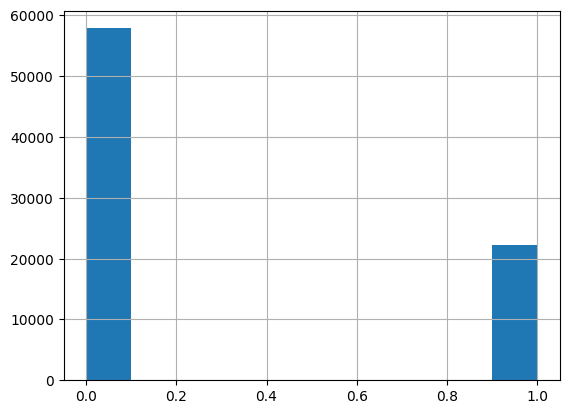

In [94]:
data.label.hist()

In [95]:
def generate_features(row):
    values = np.array(row['values'])
    date = np.array(row['dates'])
    id = np.array(row['id'])
    return {
        'mean': np.mean(values),
        'std': np.std(values),
        'min': np.min(values),
        'max': np.max(values),
        'median': np.median(values),
        'skew' : skew(values),
        'kurtosis' : kurtosis(values),
        'date' : date,
        'id' : id
    }

In [96]:
pre_features = data.apply(generate_features, axis=1, result_type='expand')
pre_features

mean       std       min   max    median      skew  kurtosis  \
0      0.023710  1.337272 -4.840000  3.49 -0.110000 -0.304166  1.889654   
1     -0.310777  1.556337 -3.534409  2.92 -0.274409 -0.011952 -0.107257   
2     -0.046042  1.065023 -1.950000  2.61 -0.145000  0.377148 -0.272738   
3     -0.130000  1.158201 -2.220000  2.49 -0.345000  0.112395 -0.849629   
4     -0.270536  1.270529 -2.500000  2.87 -0.475000  0.398655 -0.587199   
...         ...       ...       ...   ...       ...       ...       ...   
79995  0.163818  1.303965 -3.640000  2.56  0.160000 -0.717290  0.981033   
79996 -0.112555  1.216413 -2.590000  2.16 -0.180000  0.111317 -1.059264   
79997 -0.201373  1.182551 -2.890000  2.27 -0.140000 -0.055628 -0.239816   
79998 -0.075397  1.491254 -2.850000  3.11  0.240000 -0.142759 -0.978812   
79999 -0.274635  1.407661 -3.050000  2.87  0.003350 -0.258770 -0.657855   

                                                    date     id  
0      [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...  19114  
1      [2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...  22769  
2      [2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...  76935  
3      [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...  66297  
4      [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   2191  
...                                                  ...    ...  
79995  [2018-10-01, 2018-11-01, 2018-12-01, 2019-01-0...  71474  
79996  [2016-07-01, 2016-08-01, 2016-09-01, 2016-10-0...  36908  
79997  [2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...  63517  
79998  [2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...  94731  
79999  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...  98870  

[80000 rows x 9 columns]

In [97]:
pre_features['label'] = data['label']
pre_features_without_date = pre_features.drop(['date'], axis=1)

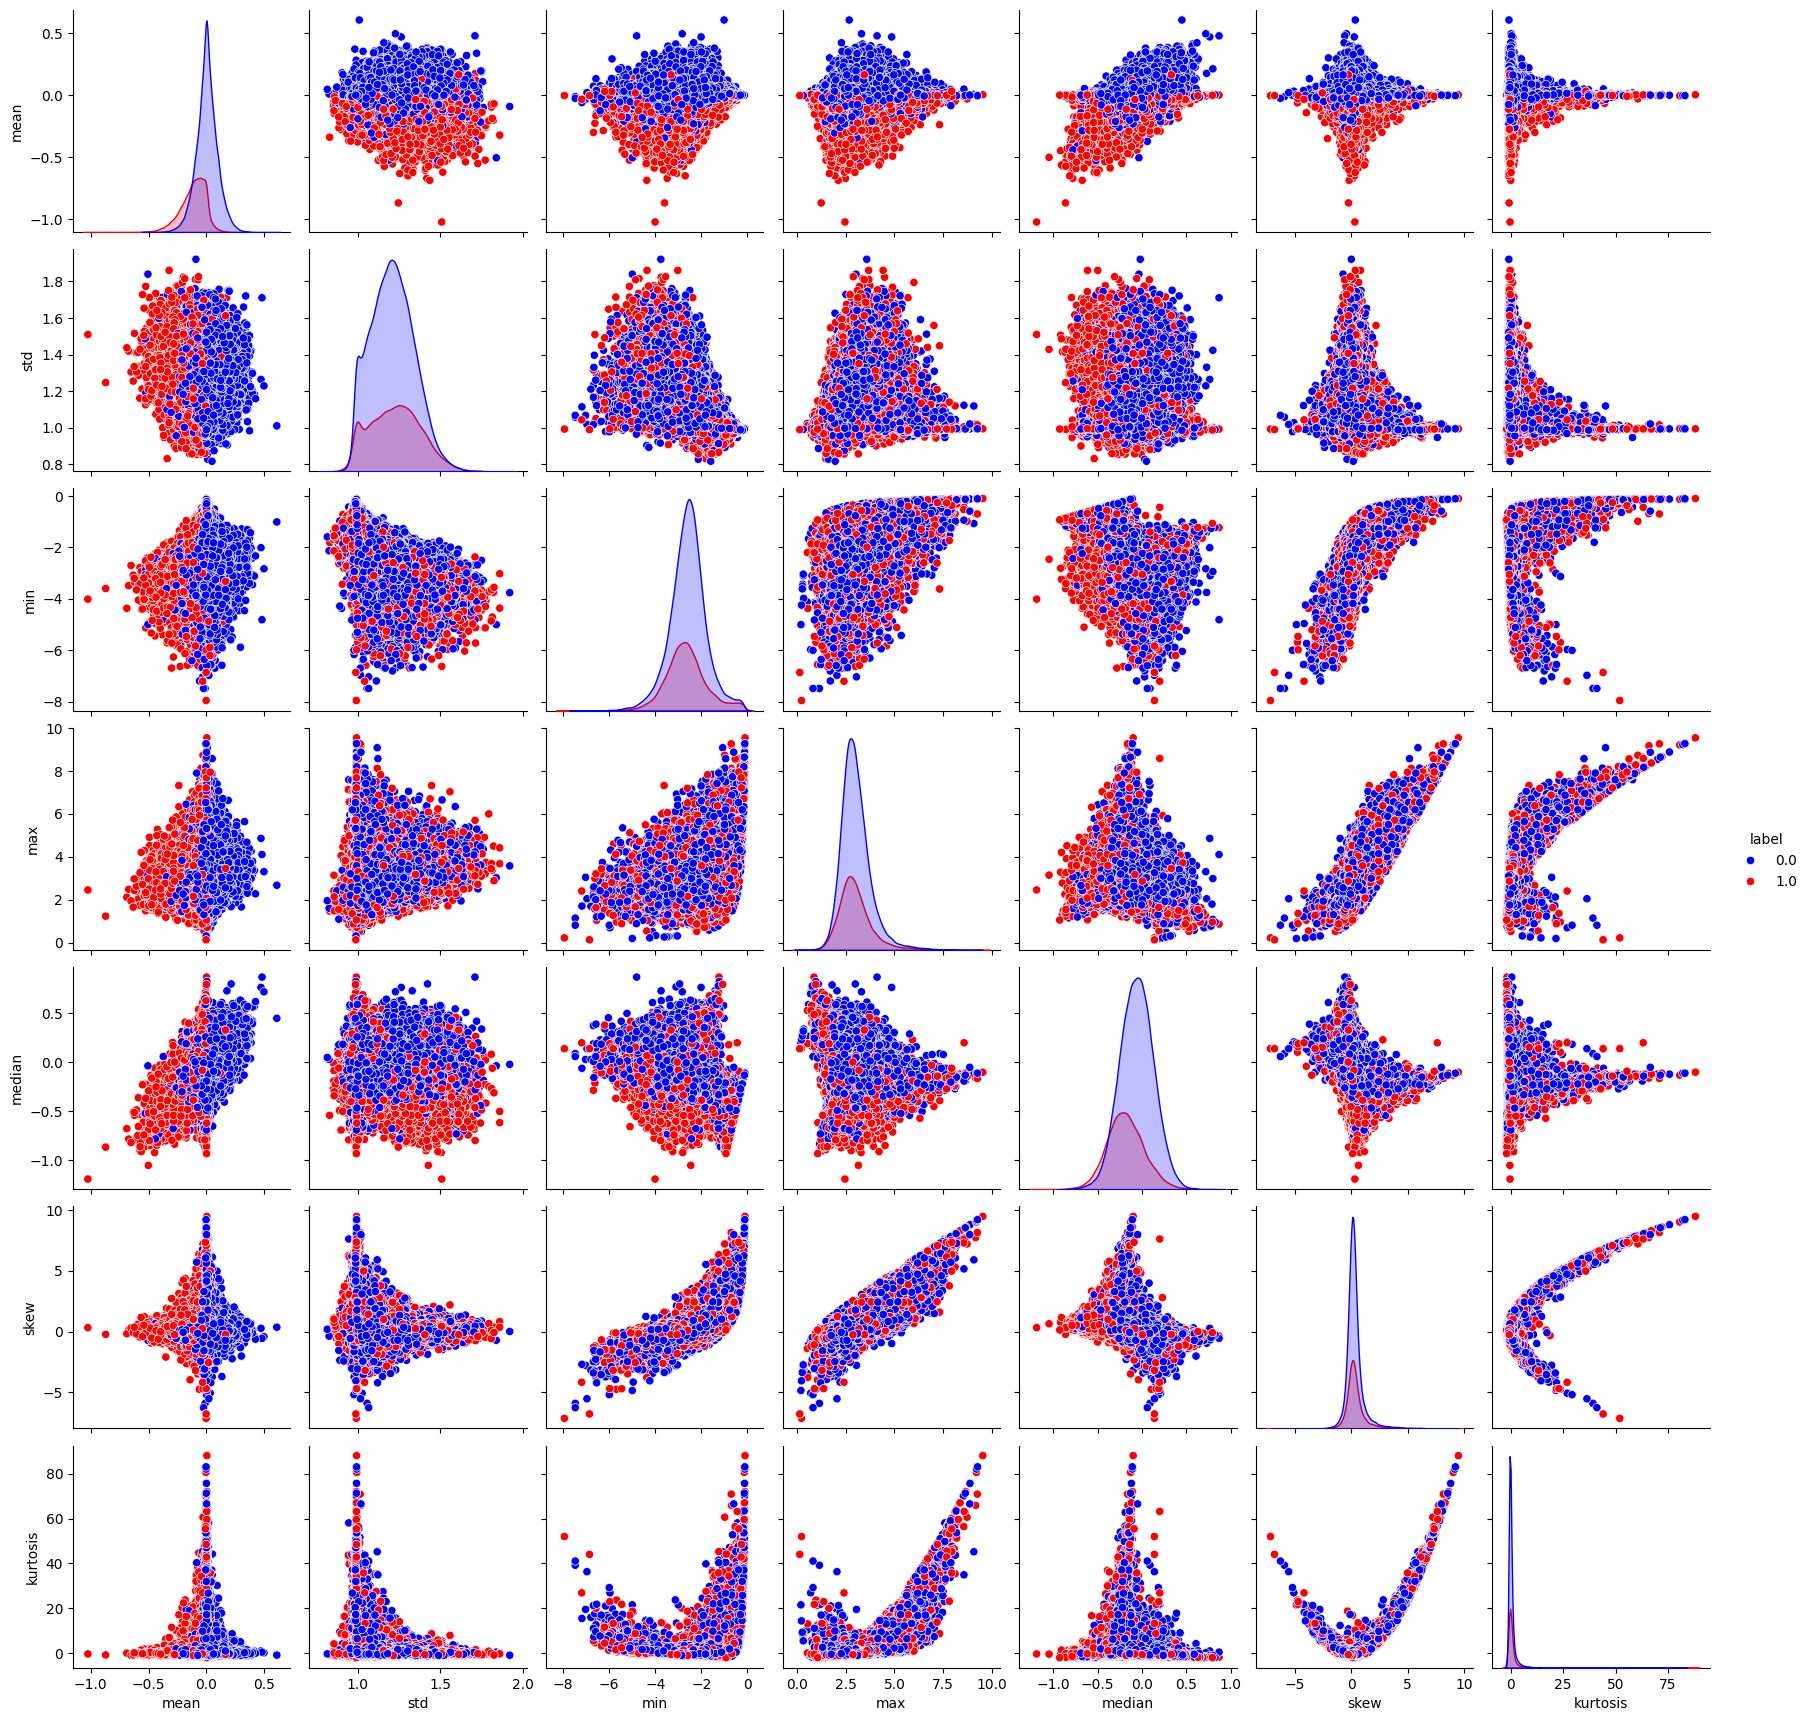

In [13]:
sns.pairplot(pre_features_without_date, hue='label', palette={1 : 'red', 0 : 'blue'})

(<Axes: title={'center': 'mean'}>, <Axes: title={'center': 'mean'}>)

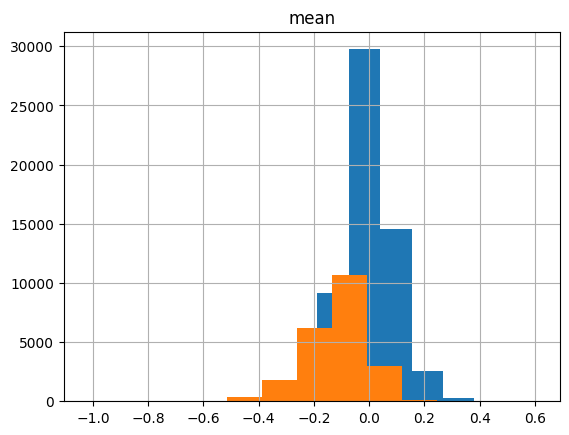

In [107]:
plt.title('mean')
pre_features_without_date.query('label == 0')['mean'].hist(), pre_features_without_date.query('label == 1')['mean'].hist()

Text(0.5, 1.0, 'std')

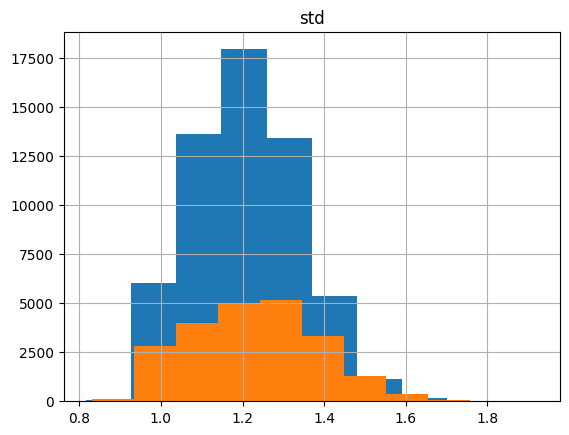

In [101]:
pre_features_without_date.query('label == 0')['std'].hist(), pre_features_without_date.query('label == 1')['std'].hist();
plt.title('std')

Text(0.5, 1.0, 'median')

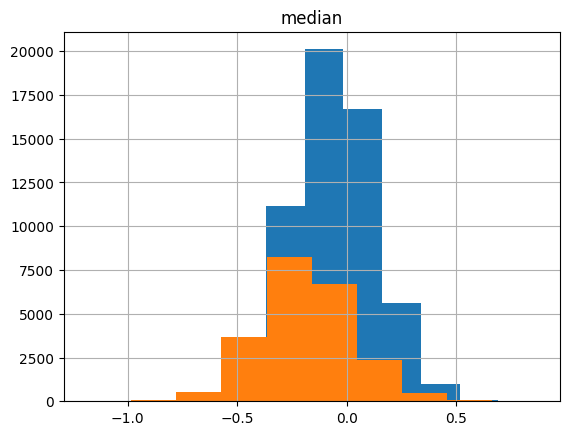

In [102]:

pre_features_without_date.query('label == 0')['median'].hist(), pre_features_without_date.query('label == 1')['median'].hist()
plt.title('median')

Text(0.5, 1.0, 'min')

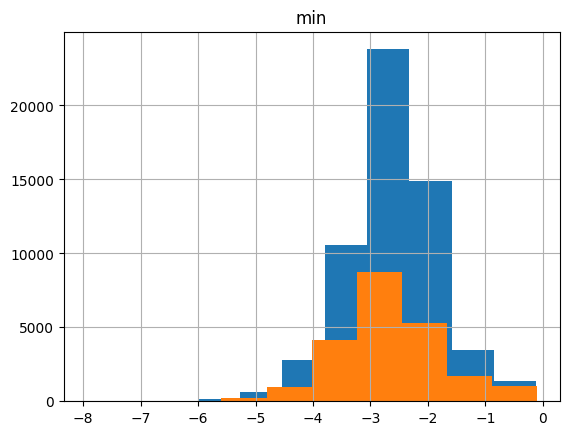

In [103]:

pre_features_without_date.query('label == 0')['min'].hist(), pre_features_without_date.query('label == 1')['min'].hist()
plt.title('min')

Text(0.5, 1.0, 'max')

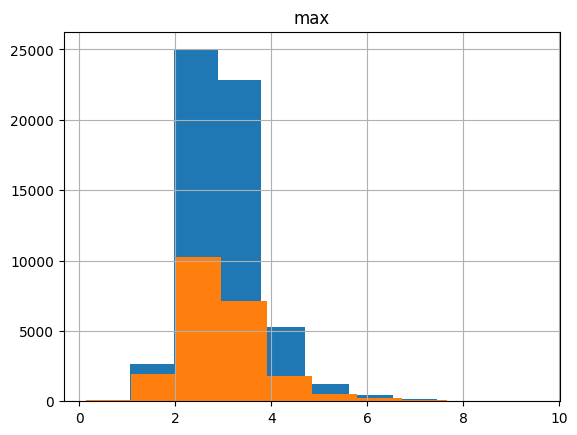

In [106]:

pre_features_without_date.query('label == 0')['max'].hist(), pre_features_without_date.query('label == 1')['max'].hist()
plt.title('max')

Text(0.5, 1.0, 'skew')

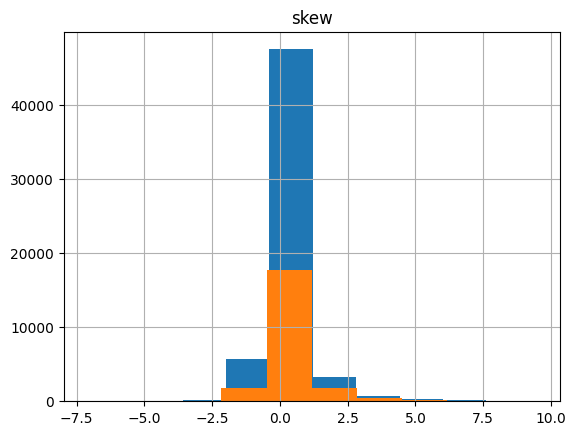

In [104]:

pre_features_without_date.query('label == 0')['skew'].hist(), pre_features_without_date.query('label == 1')['skew'].hist()
plt.title('skew')

Text(0.5, 1.0, 'kurtosis')

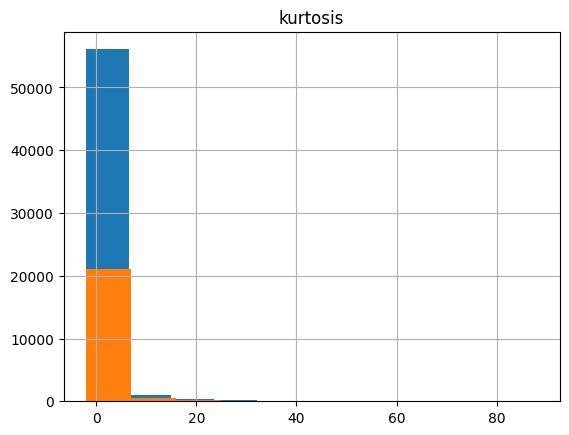

In [105]:

pre_features_without_date.query('label == 0')['kurtosis'].hist(), pre_features_without_date.query('label == 1')['kurtosis'].hist()
plt.title('kurtosis')


In [48]:
pre_features_without_date.isna().sum()

mean        0
std         0
min         0
max         0
median      0
skew        0
kurtosis    0
id          0
label       0
dtype: int64

In [49]:
for col in pre_features_without_date.columns:
    pre_features_without_date.fillna(pre_features_without_date[col].mean(), inplace=True)

In [58]:
id = pre_features_without_date['id']
pre_features_without_date.drop(['id'], axis=1, inplace=True)

0        19114
1        22769
2        76935
3        66297
4         2191
         ...  
79995    71474
79996    36908
79997    63517
79998    94731
79999    98870
Name: id, Length: 80000, dtype: object

In [53]:
scaler = MinMaxScaler()
scaled_pre_features_without_date_array = scaler.fit_transform(pre_features_without_date)
scaled_pre_features_without_date_data = pd.DataFrame(data = scaled_pre_features_without_date_array, columns=pre_features_without_date.columns)
scaled_pre_features_without_date_data

mean       std       min       max    median      skew  kurtosis  \
0      0.642090  0.700924  0.392775  0.367947  0.524288  0.411292  0.043035   
1      0.437169  0.813064  0.557664  0.308398  0.444480  0.428861  0.020846   
2      0.599357  0.561559  0.757765  0.276012  0.507298  0.452255  0.019007   
3      0.547921  0.609257  0.723666  0.263475  0.410214  0.436337  0.012597   
4      0.461822  0.666758  0.688303  0.303174  0.347109  0.453548  0.015513   
...         ...       ...       ...       ...       ...       ...       ...   
79995  0.727926  0.683874  0.544328  0.270788  0.655351  0.386453  0.032939   
79996  0.558608  0.639056  0.676937  0.229000  0.490308  0.436272  0.010268   
79997  0.504195  0.621722  0.639049  0.240492  0.509725  0.426235  0.019373   
79998  0.581373  0.779748  0.644100  0.328248  0.694185  0.420996  0.011161   
79999  0.459311  0.736957  0.618842  0.303174  0.579310  0.414021  0.014728   

       label  
0        0.0  
1        1.0  
2        0.0  
3        0.0  
4        0.0  
...      ...  
79995    0.0  
79996    1.0  
79997    0.0  
79998    0.0  
79999    1.0  

[80000 rows x 8 columns]

In [63]:
scaled_pre_features_without_date_data['id'] = id
scaled_pre_features_without_date_data

mean       std       min       max    median      skew  kurtosis  \
0      0.642090  0.700924  0.392775  0.367947  0.524288  0.411292  0.043035   
1      0.437169  0.813064  0.557664  0.308398  0.444480  0.428861  0.020846   
2      0.599357  0.561559  0.757765  0.276012  0.507298  0.452255  0.019007   
3      0.547921  0.609257  0.723666  0.263475  0.410214  0.436337  0.012597   
4      0.461822  0.666758  0.688303  0.303174  0.347109  0.453548  0.015513   
...         ...       ...       ...       ...       ...       ...       ...   
79995  0.727926  0.683874  0.544328  0.270788  0.655351  0.386453  0.032939   
79996  0.558608  0.639056  0.676937  0.229000  0.490308  0.436272  0.010268   
79997  0.504195  0.621722  0.639049  0.240492  0.509725  0.426235  0.019373   
79998  0.581373  0.779748  0.644100  0.328248  0.694185  0.420996  0.011161   
79999  0.459311  0.736957  0.618842  0.303174  0.579310  0.414021  0.014728   

       label     id  
0        0.0  19114  
1        1.0  22769  
2        0.0  76935  
3        0.0  66297  
4        0.0   2191  
...      ...    ...  
79995    0.0  71474  
79996    1.0  36908  
79997    0.0  63517  
79998    0.0  94731  
79999    1.0  98870  

[80000 rows x 9 columns]

In [64]:
X = scaled_pre_features_without_date_data.drop(['label'], axis=1)
y = scaled_pre_features_without_date_data.label
X.set_index('id', inplace=True)
# , 'min', 'max', 'skew', 'kurtosis'

In [81]:
scaled_pre_features_without_date_data.to_csv('scaled_pre_features_without_date_data.csv', index=False)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [76]:

clf = RandomForestClassifier(class_weight='balanced', max_depth=11, min_samples_leaf = 21, min_samples_split=2, n_estimators=91, random_state=42, n_jobs=-1).fit(X, y)
joblib.dump(clf, 'random_forest_model.pkl')


['random_forest_model.pkl']

In [43]:

param = {'n_estimators' : range(1, 100, 10), 'max_depth': range(1, 100, 10), 'min_samples_leaf' : range(1, 40, 5), 'min_samples_split' : range(2, 30, 5), 'class_weight': ['balanced']}
grid_clf = GridSearchCV(clf, param, scoring='roc_auc', n_jobs=-1, cv=5)
grid_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'max_depth': range(1, 100, 10),
                         'min_samples_leaf': range(1, 40, 5),
                         'min_samples_split': range(2, 30, 5),
                         'n_estimators': range(1, 100, 10)},
             scoring='roc_auc')

In [78]:
X

mean       std       min       max    median      skew  kurtosis
id                                                                         
19114  0.642090  0.700924  0.392775  0.367947  0.524288  0.411292  0.043035
22769  0.437169  0.813064  0.557664  0.308398  0.444480  0.428861  0.020846
76935  0.599357  0.561559  0.757765  0.276012  0.507298  0.452255  0.019007
66297  0.547921  0.609257  0.723666  0.263475  0.410214  0.436337  0.012597
2191   0.461822  0.666758  0.688303  0.303174  0.347109  0.453548  0.015513
...         ...       ...       ...       ...       ...       ...       ...
71474  0.727926  0.683874  0.544328  0.270788  0.655351  0.386453  0.032939
36908  0.558608  0.639056  0.676937  0.229000  0.490308  0.436272  0.010268
63517  0.504195  0.621722  0.639049  0.240492  0.509725  0.426235  0.019373
94731  0.581373  0.779748  0.644100  0.328248  0.694185  0.420996  0.011161
98870  0.459311  0.736957  0.618842  0.303174  0.579310  0.414021  0.014728

[80000 rows x 7 columns]

In [77]:
# best_clf = grid_clf.best_estimator_
load_clf = joblib.load('random_forest_model.pkl')
y_pred = load_clf.predict(X_test)
roc_auc_score(y_test, y_pred)

(0.7617028632754826, array([1., 1., 0., ..., 0., 1., 0.]))